### Importing libs

In [8]:

import pandas as pd
import pydicom as pdcm
import cv2 as cv
import matplotlib.pyplot as plt
import os 
import numpy as np

### Carregando uma imagem

In [9]:
img_path = r"data\base_02\Isquêmico\Iran C A Cunha\TC_Brian_IranCAC_avcI00063.dcm"
img = pdcm.dcmread(img_path, 0)


### Funções Lucas

In [10]:
def m_uint8(img):
    from cv import convertScaleAbs
    img[img < 0] = 0
    return convertScaleAbs(img)
def AreaLabel(I):
    """
    Calcular a Area de atraves do bwlabel para uma imagem binaria.
    I - imagem.
    [L,num] = bwlabel(___) also returns num, the number of connected
    objects found in BW. And L returns the label matrix L that contains
    labels for the 8-connected objects found in BW. The label matrix, L,
    is the same size as BW.
    """
    import numpy as np
    import cv
    connectivity = 8
    output = cv.connectedComponentsWithStats(I, connectivity, cv.CV_8U)
    L = output[1]  # Label matrix
    area = [np.sum(L == x) for x in range(0, output[0])]  # Number of labels
    # Return valor, indice and L
    return np.sort(area), np.argsort(np.unique(area)),L

def withinSkull(imgOrig):
    """
    fuzzy c-mean image segmentation with weighted
    :param imgOrig: grayscale image
    :param count_debug:
    :return: imgUtil: 2d array
        Multiplicao de imgOrig e skull,
    :return: skullInside: 2d array
        Parte interior do cerebro
    :return: skull: 2d array
        Cerebro sendo 1, resto sendo 0
    :return: se: 2d array
        Elementro estruturante 19x19
    """
    from os.path import abspath, join, dirname
    import numpy as np
    import cv
    import sys

    #sys.path.insert(0, abspath(join(dirname(__file__), '..')))

    int1 = np.uint8(1)
    int0 = np.uint8(0)
    b_matrix = np.where(imgOrig >= 255, int1, int0)

    # Fechamento
    # Array of 19x19
    ee_str = np.array((
        [[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]
    ), dtype=np.uint8)

    for x in range(0, 9):
        b_matrix = cv.erode(cv.dilate(b_matrix, ee_str), ee_str)

    _, index, L = AreaLabel(b_matrix)

    # Calcular a Area de todos os label encontrados.
    if len(index) >= 1:
        skull = np.where(L == index[0], int0, int1)
    elif len(index) == 0:
        skull = 1 - L

    # [Matheus] Codigo para representar 'floodfill' do MATLAB
    im_flood_fill = np.copy(skull)
    h, w = skull.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    # Floodfill from point (0, 0)
    cv.floodFill(im_flood_fill, mask, (0, 0), 255)
    # Invert floodfilled image
    # Combine the two images to get the foreground
    skull_inside = np.bitwise_or(skull, cv.bitwise_not(im_flood_fill))

    # Segunda Etapa
    # Realizar uma erosao
    # Obs: realizar uma erosao umas 5 ou 6 vezes para retirar as bordas.
    ee_str_2 = np.ones((5, 5), dtype=np.uint8)  # ElementoEstruturante 15

    for i in range(0, 3):  # 10
        skull_inside = cv.erode(1 - skull, ee_str_2)

    # [Lucas] - Nao pode haver aberturas no osso do cranio
    kernel = np.ones((5, 5), np.uint8)
    skull_inside = cv.erode(skull_inside, kernel, iterations=12)
    skull_inside = cv.dilate(skull_inside, kernel, iterations=12)

    valor, index, L = AreaLabel(skull_inside)
    if len(index) > 1:
        skull_inside = np.where(L == index[2], int1, int0)
    elif len(index) == 0:
        skull_inside = L.copy()
    else:
        skull_inside = np.where((1 - skull) == index,
                                int1, int0)
    # img_util, skull_inside, skull, ee_str
    return m_uint8(imgOrig) * skull_inside, \
           skull_inside, skull, ee_str


def extract_brain(src, inf_limit=0, sup_limit=100):
    # Restrict the HU values to be between 0 and 255
    brain_image = np.where(src < inf_limit, 0, src)
    new_img = np.where(brain_image > sup_limit, 255, brain_image)

    # Get only the skull
    img = np.asarray(new_img, np.uint8)
    binary_image = np.where(img != 255, 0, img)
    # binary_image = cv.dilate(binary_image, kernel=(5, 5), iterations=1)
    # Remove the skull from the original image
    new_img = np.where(binary_image == 255, 0, new_img)
    new_img = np.where(new_img > sup_limit, 0, new_img)

    # Apply threshold
    ret, binary_image = cv.threshold(new_img, 0, 255, cv.THRESH_BINARY)
    binary_image = np.asarray(binary_image, np.uint8)

    # Get the binaryImage biggest component
    connectivity = 4
    _, labels, stats, centroids = cv.connectedComponentsWithStats(binary_image, connectivity, cv.CV_8U)

    img_max = np.zeros(binary_image.shape, binary_image.dtype)
    try: 
        large_component = 1 + stats[1:, cv.CC_STAT_AREA].argmax()
    except ValueError:
        return np.zeros(img.shape)

    img_max[labels == large_component] = 255
    img_max[labels != large_component] = 0

    # Compare the biggest component with the original image and get only the intersection
    output = np.where(img_max == 255, new_img, 0)

    # cv.imshow('Image', np.asarray(output, np.uint8))
    # cv.waitKey(0)
    np.asarray(output, np.uint8)[np.asarray(output, np.uint8) < 0] = 0
    # print(np.asarray(output, np.uint8))

    # return np.asarray(output, np.uint8)
    return output

def brain(img):
    # cv.imshow(' 1  Input image', img)

    #################################
    # 1 - Normalizacao
    #################################
    img_norm = np.zeros_like(img)
    cv.normalize(img, img_norm, 0, 255, cv.NORM_MINMAX)
    img_norm = cv.convertScaleAbs(img_norm)

    ret, img_bin = cv.threshold(img_norm, 240, 255, cv.THRESH_BINARY)


    # cv.imshow(' 2 - Image bin', img_bin)
    
    # #########################################################
    # connectivity = 4
    # output = cv.connectedComponentsWithStats(img_bin, 4, cv.CV_8U)
    # labels = output[1]  # AM: Rotulo das componentes
    # stats = output[2]  # AM: Estatistica das componentes
    # centroids = output[3]  # AM: Centroids das componentes
    # #########################################################
    
    # img_max_ = np.zeros(img_bin.shape, img_bin.dtype)
    # img_max_2 = np.zeros(img_bin.shape, img_bin.dtype)

    # largecomponent1 = 1 + stats[1:, cv.CC_STAT_AREA].argmax()
    # largecomponent2 = 1 + stats[1:, cv.CC_STAT_AREA].argmax()

    # stats[largecomponent1, cv.CC_STAT_AREA] = largecomponent1
    # stats[largecomponent2, cv.CC_STAT_AREA] = largecomponent2

    # img_max_[labels == largecomponent1] = 255
    # img_max_2[labels != largecomponent2] = 255 

    kernel = np.ones((3, 3), np.uint8)
    img_bin = cv.dilate(img_bin, kernel, iterations=5)

    # cv.imshow(' 3 - Apenas o osso do cranio', img_bin)

    #Diferença  
    dif = img - img_bin
    # cv.imshow(' 4 - Diferenca 1 e 3', dif)


    dif = dif * 255
    ret, thresh = cv.threshold(dif, 0, 255, cv.THRESH_BINARY) 
    # cv.imshow(' 5 - Thresh diferença', thresh)


    #################################
    # Detecção da maior componente
    #################################
    img_norm_2 = np.zeros_like(img)   

    #################################
    # Normalizacao da diferença
    #################################
    cv.normalize(thresh, img_norm_2, 0, 255, cv.NORM_MINMAX)
    img_norm_2 = cv.convertScaleAbs(img_norm_2)

    #########################################################
    connectivity = 4
    output = cv.connectedComponentsWithStats(img_norm_2, 4, cv.CV_8U)
    labels = output[1]  # AM: Rotulo das componentes
    stats = output[2]  # AM: Estatistica das componentes
    centroids = output[3]  # AM: Centroids das componentes

    #########################################################

    
    img_max_ = np.zeros(img_norm_2.shape, img_norm_2.dtype)

    largecomponent1 = 1 + stats[1:, cv.CC_STAT_AREA].argmax()

    stats[largecomponent1, cv.CC_STAT_AREA] = largecomponent1

    img_max_[labels == largecomponent1] = 255
    img_max_[labels != largecomponent1] = 0

    # cv.imshow(' 6 - Maior componente do thresh diferenca', img_max_)

    dif = (dif / 255)   
    # cv.imshow('  - TESTE', dif)

    img_max_ = dif - img_max_   
    # cv.imshow('  - TESTE - 2', img_max_)

    #################################
    # Normalizacao da diferença
    #################################
    img_norm_3 = np.zeros_like(img_max_)

    cv.normalize(img_max_, img_norm_3, 0, 255, cv.NORM_MINMAX)
    img_norm_3 = cv.convertScaleAbs(img_norm_3)


    #################################    
    # Clip Contrast
    #################################
    mean, std = cv.meanStdDev(img_norm_3) #Retirei por ultimo
    img_norm_3[img_norm_3 < mean] = 0

    # cv.imshow(' TESTE 3 imgnorm_3', img_norm_3)

    # cv.imshow(' TESTE 4 imgnorm_3/255', (img_norm_3/255))

    new_image = (dif - (img_norm_3))
    new_image[new_image < 0] = 0

    # cv.imshow(' 7 - Output image', new_image)

    cv.waitKey()
    return new_image



## Carregando imagem e processando

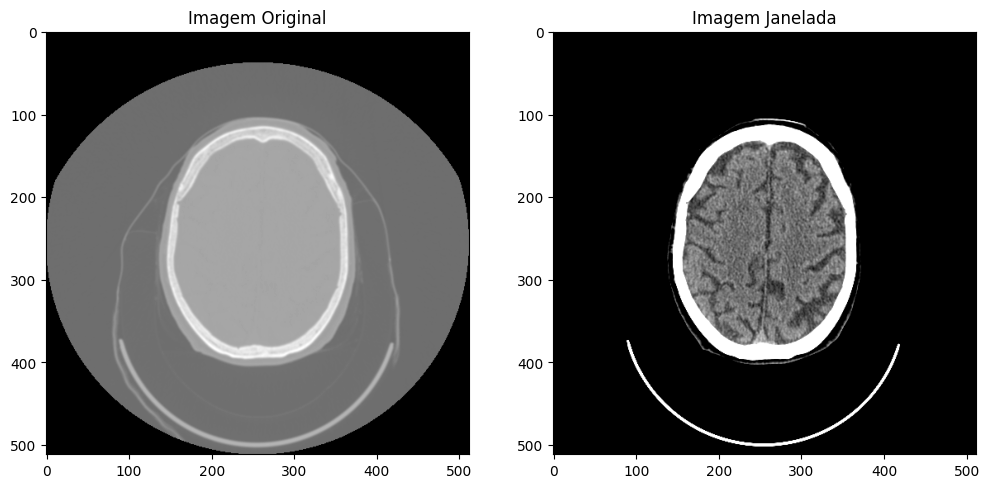

In [11]:
# Carregar a imagem DICOM
path_to_dicom = r"data\base_02\Isquêmico\Iran C A Cunha\TC_Brian_IranCAC_avcI00093.dcm"
img_dicom = pdcm.dcmread(path_to_dicom)

# Obter os valores de pixel da imagem
pixel_array = img_dicom.pixel_array

# Definir os parâmetros de janelamento (window center e window width)
window_center = img_dicom.WindowCenter
window_width = img_dicom.WindowWidth

# Aplicar janelamento aos valores de pixel
windowed_image = pixel_array * img_dicom.RescaleSlope + img_dicom.RescaleIntercept # y = ax + b

# Ajustar os valores de pixel de acordo com os parâmetros de janelamento
windowed_image = windowed_image.clip(min=window_center - window_width/2, max=window_center + window_width/2)

# Exibir a imagem original e a imagem janelada
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(pixel_array, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(windowed_image, cmap='gray')
plt.title('Imagem Janelada')

plt.show()

In [12]:
window_center
window_width
img_dicom.RescaleSlope
img_dicom.RescaleIntercept
type(windowed_image)

numpy.ndarray

In [13]:
img_dicom.PatientName

'IRAN COSTA DE ALMEIDA CUNHA'

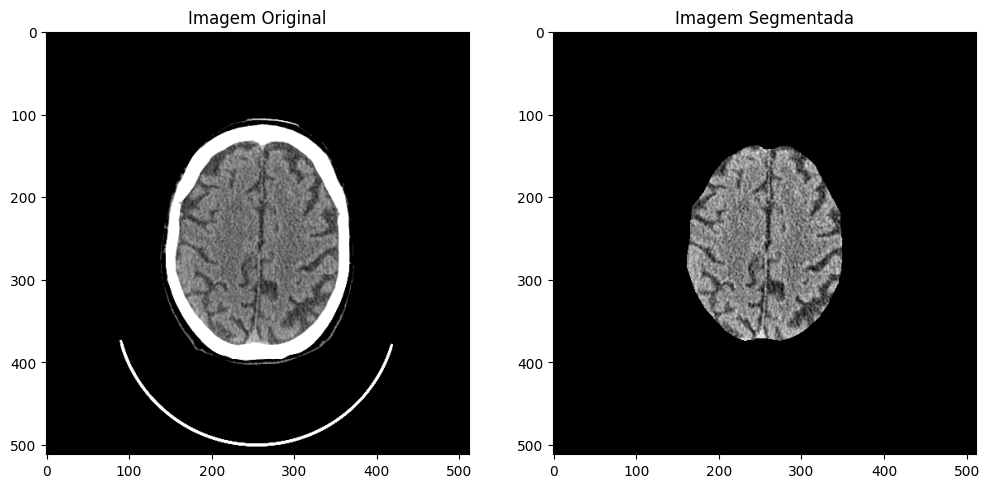

In [18]:
brain_image = brain(windowed_image)
# Exibir a imagem original e a imagem janelada
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(windowed_image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(brain_image, cmap='gray')
plt.title('Imagem Segmentada')

plt.show()

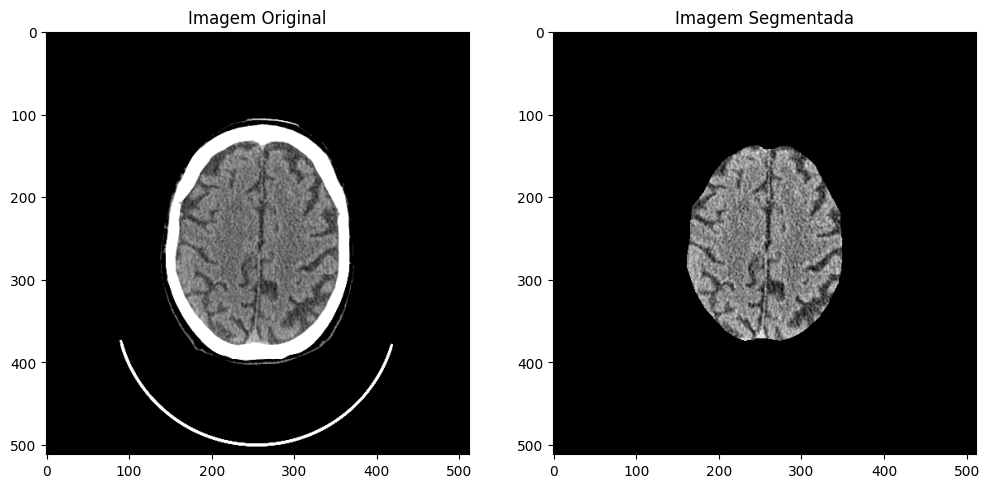

In [19]:
test_img = extract_brain(windowed_image)

# Exibir a imagem original e a imagem janelada
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(windowed_image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(brain_image, cmap='gray')
plt.title('Imagem Segmentada')

plt.show()
